In [1]:
#Import necessary modules
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, when, lag, round, sqrt, pow, sum as sum_func, max as max_func,row_number, lit, min as min_func, abs, avg, count
from pyspark.sql.types import StructType, StructField, LongType, StringType, BooleanType, DoubleType, IntegerType
from pyspark.sql.functions import monotonically_increasing_id
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
os.environ["HADOOP_HOME"] = "C:\\hadoop"
os.environ["PATH"] += os.pathsep + "C:\\hadoop\\bin"

In [3]:
#Create spark session
spark = SparkSession.builder \
    .appName("Formation App") \
    .config("spark.ui.showConsoleProgress", "true") \
    .getOrCreate()

In [4]:
#Select only desired columns and apply schema
schema = StructType([
    StructField("gameId", LongType(), True),
    StructField("playId", LongType(), True),
    StructField("nflId", DoubleType(), True),
    StructField("frameId", LongType(), True),
    StructField("x", DoubleType(), True),
    StructField("y", DoubleType(), True),
    StructField("frameType", StringType(), True)
])


folder = "data/tracking/"
files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]

trackingDf = spark.read.schema(schema).parquet(*files)

#Filter and select tracking data just before the snap - to determine if there is any pre-snap motion
snapEventsDf = trackingDf.filter(col("frameType") == "SNAP").groupby("gameId", "playId").agg(min_func("frameId").alias("snapEvent"))

#Join with full data to get last second before snap, using the last 10 frames (update rate of 0.1 seconds)
presnapDf = trackingDf.join(snapEventsDf, ["gameId", "playId"]).filter(col("frameId") < col("snapEvent")).filter(col("frameId") >= (col("snapEvent") - 10))

In [5]:
schema = StructType([
    StructField("gameId", LongType(), True),
    StructField("playId", LongType(), True),
    StructField("yardlineNumber", LongType(), True),
    StructField("expectedPointsAdded", DoubleType(), True),
    StructField("offenseFormation", StringType(), True), 
    StructField("receiverAlignment", StringType(), True), 
    StructField("pff_passCoverage", StringType(), True),
    StructField("pff_manZone", StringType(), True),
    StructField("pff_runConceptPrimary", StringType(), True)
])

playsDf = spark.read.schema(schema).parquet("data/plays.parquet")

In [6]:
playsDf.select("expectedPointsAdded").describe().show()


+-------+--------------------+
|summary| expectedPointsAdded|
+-------+--------------------+
|  count|               16124|
|   mean|-0.02938121470672...|
| stddev|   1.397405113935573|
|    min|   -13.0236002178863|
|    max|     8.6989859752357|
+-------+--------------------+



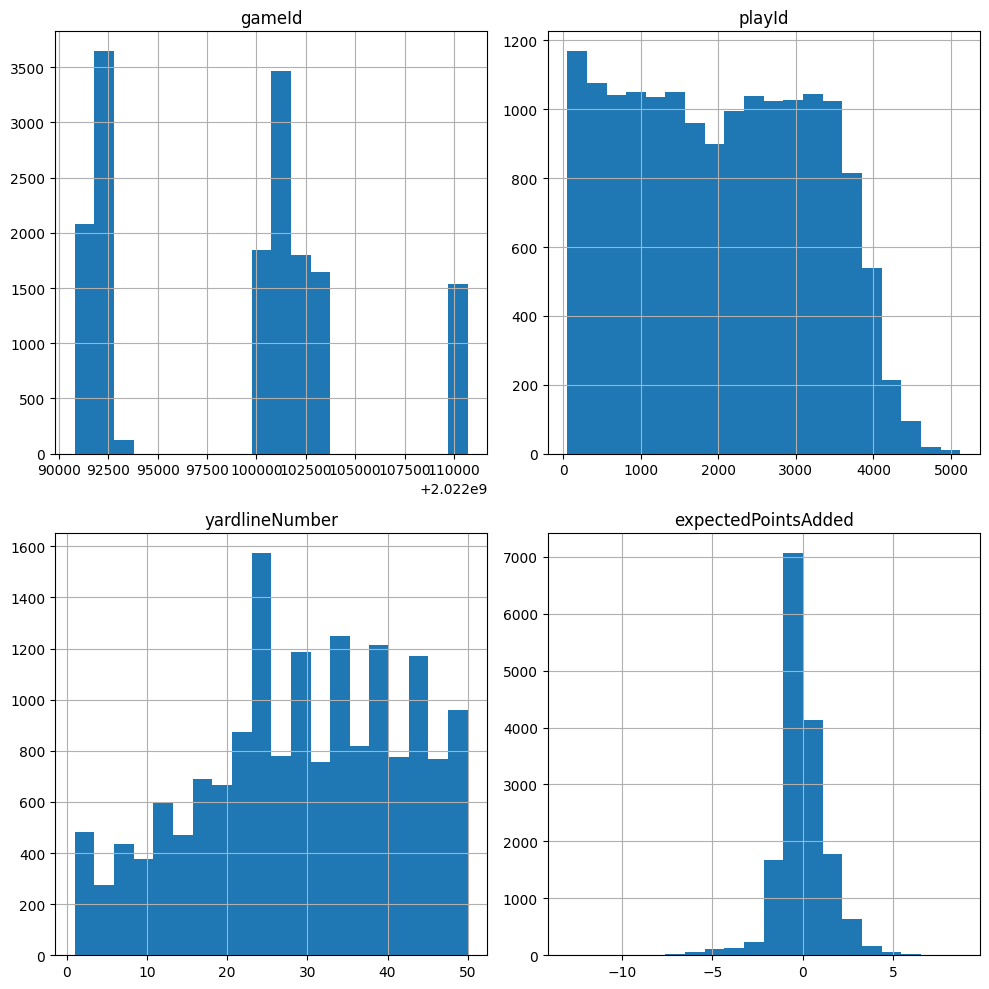

In [7]:
#THIS IS JUST FOR ONE TIME VIEWING - not included in full workflow
df = playsDf.toPandas()

df.hist(bins=20, figsize=(10, 10))
plt.tight_layout()
plt.show()


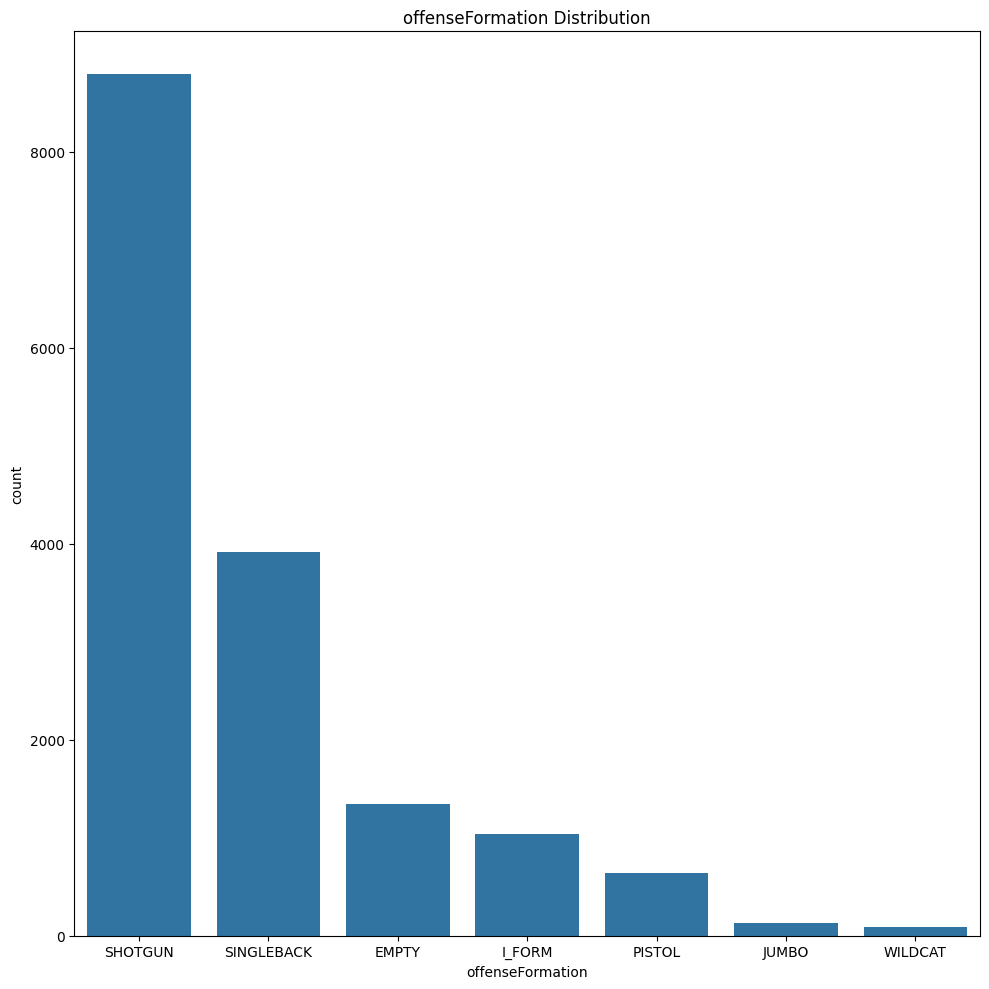

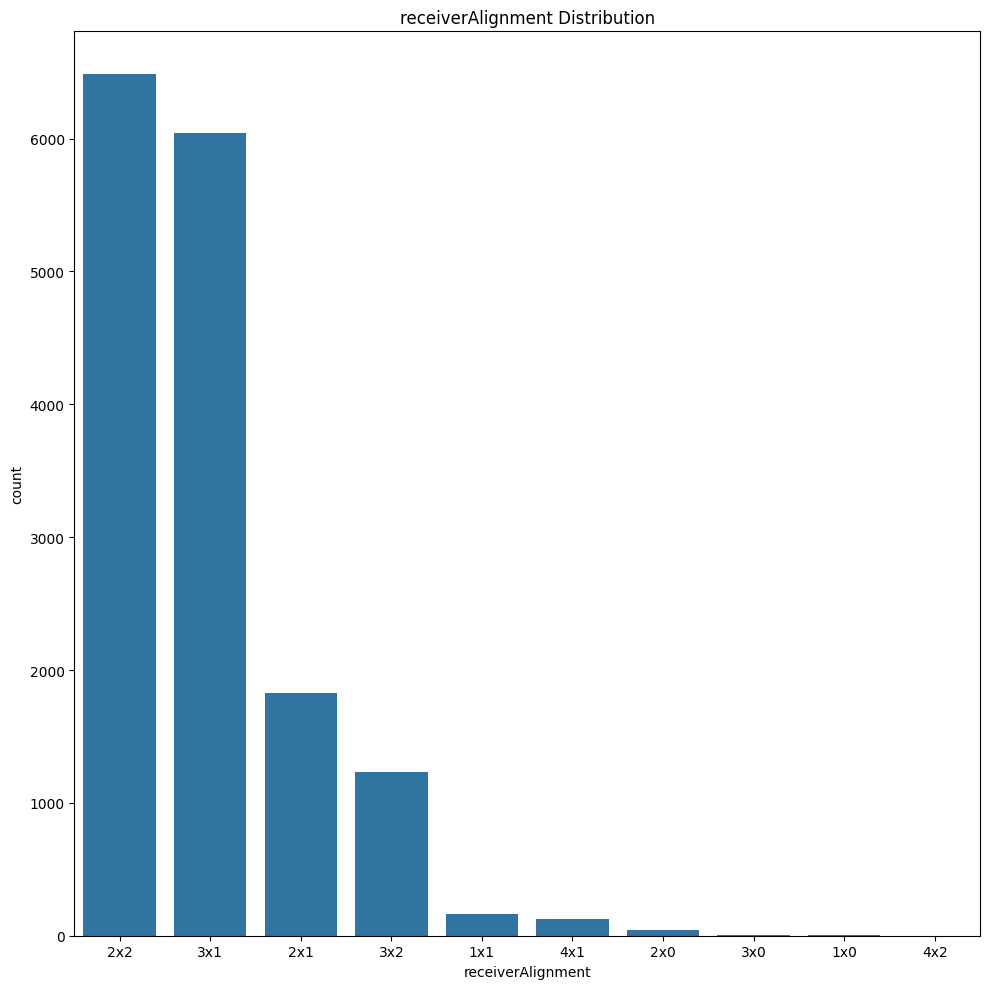

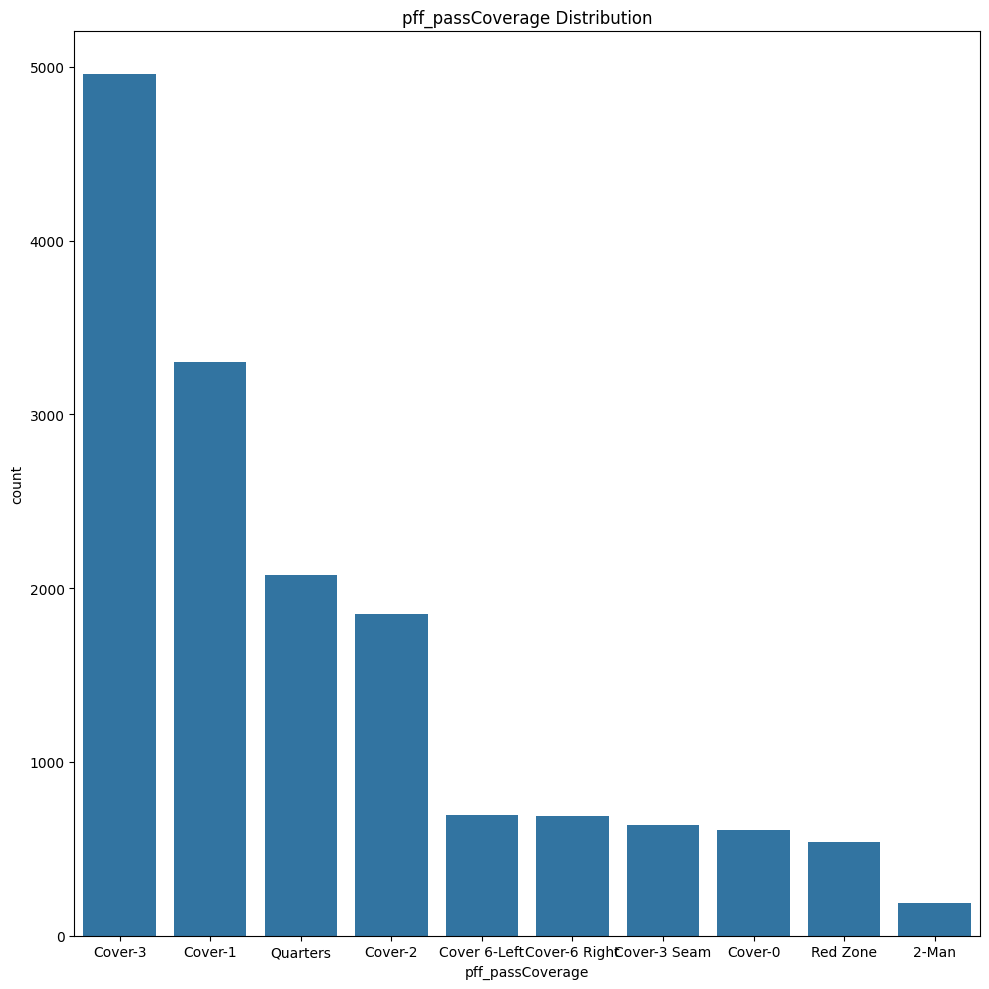

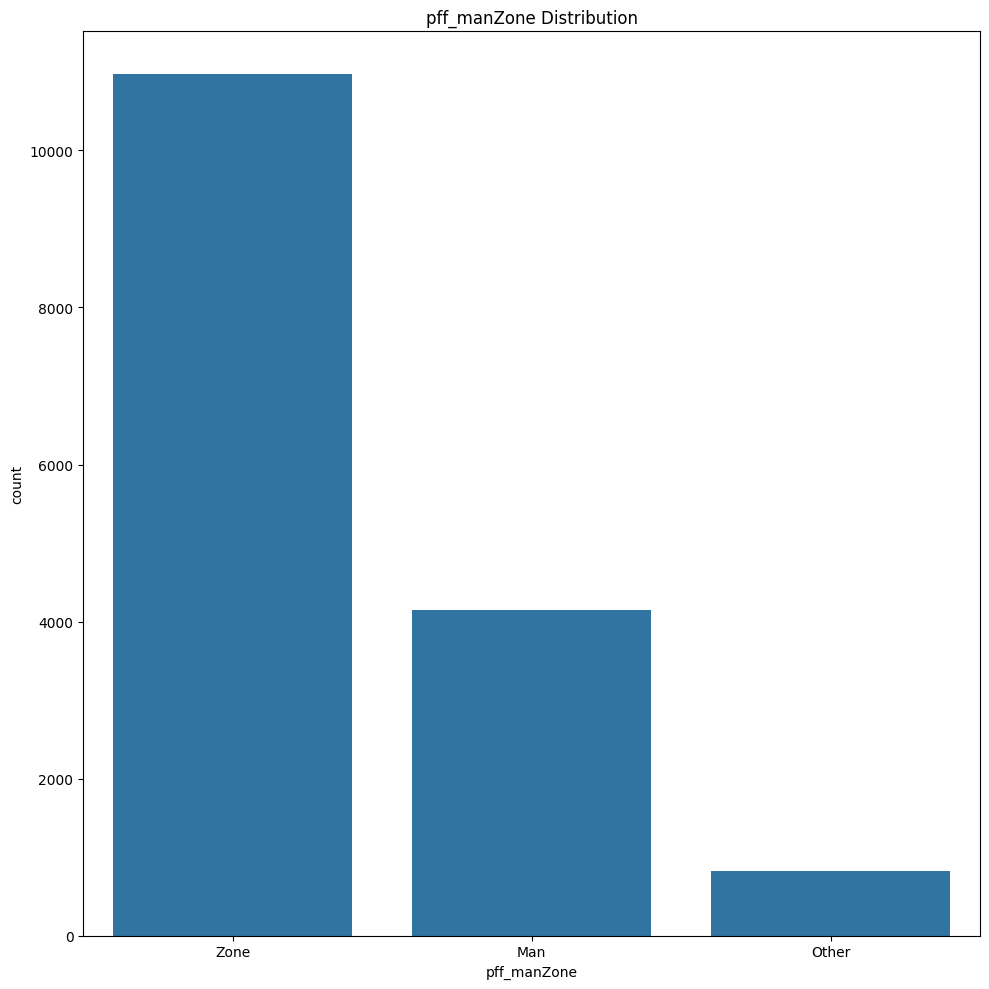

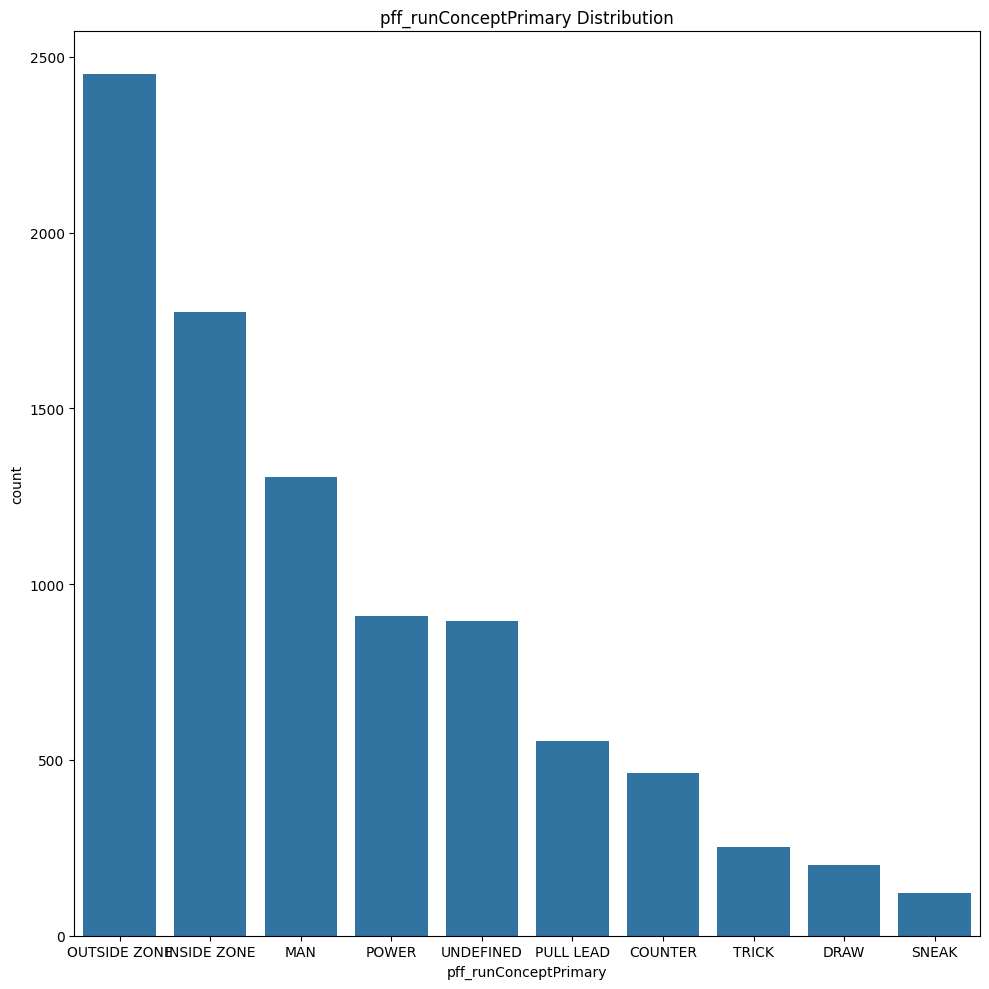

In [ ]:
#THIS IS JUST FOR ONE TIME VIEWING - not included in full workflow
textCols = df.select_dtypes(include = ['object', 'category']).columns

for columnName in textCols:
    plt.figure(figsize = (10,10))
    sns.countplot(data=df, x=columnName, order=df[columnName].value_counts().index[:15])
    plt.title(f"{columnName} Distribution")
    plt.tight_layout()
    plt.show()


In [9]:
#Read in columns of interest from players data source 
schema = StructType([
    StructField("nflId", LongType(), True), 
    StructField("position", StringType(), True)
])

#Read in players datasource and apply schema
playersDf = spark.read.schema(schema).parquet("data/players.parquet")

In [10]:
#Add positions column, through a join
presnapDf = presnapDf.join(playersDf.select("nflId", "position"), on="nflId", how="left")

#Get rid of playersDf from cache as it obsolete
playersDf.unpersist()

#Position classifications for later usage
offensivePositions = ["QB", "RB", "FB", "HB", "WR", "TE", "LT", "LG", "C", "RG", "RT"]
defensivePositions = ["CB", "S", "FS", "SS", "MLB", "OLB", "ILB", "LB", "DT", "DE", "NT", "DB"]

#Create a classifier column for if the player is on offence or defence
presnapDf = presnapDf.withColumn("isOffence",when(col("position").isin(*offensivePositions), True).when(col("position").isin(*defensivePositions), False).otherwise(lit(None)).cast(BooleanType()))

#--------------------------------------------------Safety feature engineering---------------------------------------------------
#Select only the safeties
safetyDf = presnapDf.filter(col("position").isin(["SS", "FS"]))

#Drop redundant columns
safetyDf.drop("frameId", "frameType", "snapEvent", "isOffence")

#Get the yardline of the play
safetyDf = safetyDf.join(playsDf.select("gameId", "playId", "yardlineNumber"), on = ["gameId", "playId"], how = "left")


#Determine which direction the offence is facing
safetyDf = safetyDf.withColumn("play_direction", when(col("x") < col("yardlineNumber"), "right").otherwise("left"))

#Fix in the line of scrimmage, using the play direction, this is so that "line_of_scrimmage" is in the same units as "x"
safetyDf = safetyDf.withColumn("line_of_scrimage",when(col("play_direction") == "left", 100 - col("yardlineNumber")).otherwise(col("yardlineNumber")))

#Determine safety depth
safetyDf = safetyDf.withColumn("distance", abs(col("x") - col("line_of_scrimage")))

#Select only the last frame, this will have the distance a moment before the snap
frameGroupByDf = safetyDf.groupBy("nflId", "gameId", "playId").agg(max_func("frameId").alias("frameId"))

#what?
safetyDf = safetyDf.join(frameGroupByDf, on = ["nflId","gameId", "playId", "frameId"], how = "inner")

#Create the two features by averaging the safety depth and creating a count of safeties
safetyDf = safetyDf.groupBy("gameId", "playId").agg(avg("distance").alias("avgSafetyDistance"), count("distance").alias("numSafeties"))


In [11]:
#--------------------------------------------------------Pre snap motion engineering---------------------------------------------------

#Drop redundant columns
presnapDf = presnapDf.drop("frameId", "frameType", "snapEvent", "position")

#Formalise the sequence of the dataframe through an id to be used in a partition windw
presnapDf = presnapDf.withColumn("sequenceId", monotonically_increasing_id())
sparkWindow = Window.partitionBy("gameId", "playId", "nflId").orderBy("sequenceId")

#Over the window (per player per play) determine their position compared to the last data point
presnapDf = presnapDf.withColumn("prevX", round(lag("x").over(sparkWindow), 2))
presnapDf = presnapDf.withColumn("prevY", round(lag("y").over(sparkWindow), 2))

#Calculate cumulative distance
presnapDf = presnapDf.withColumn("cumulativeDistance", round(when(col("prevX").isNull() | col("prevY").isNull(), 0.0).otherwise(sqrt(pow(col("x") - col("prevX"), 2) + pow(col("y") - col("prevY"), 2))),5))

#Sum all the movement values - this gives total distance moved in a second
playerMotion = presnapDf.groupBy("gameId", "playId", "nflId", "isOffence").agg(sum_func("cumulativeDistance").alias("distanceMoved"))

presnapDf.unpersist()

#Using a threshold of 2 yards in the 1 second time frame, determine if the player was in motion
playerMotion = playerMotion.withColumn("motion", col("distanceMoved") > 2)

#Determine if any player on each side was in motion
playMotion = playerMotion.groupBy("gameId", "playId", "isOffence").agg(max_func("motion").alias("isMotion"))

#Create final result
playMotion = playMotion.select("gameId", "playId", "isOffence", "isMotion")

#Move each play onto one row for an easier join with the rest of the data
playMotion = playMotion.withColumn("isOffenceMoving", when(col("isOffence") == True, col("isMotion")))\
                   .withColumn("isDefenceMoving", when(col("isOffence") == False, col("isMotion")))\
                   .groupBy("gameId", "playId")\
                   .agg(max_func("isOffenceMoving").alias("isOffenceMoving"),
                        max_func("isDefenceMoving").alias("isDefenceMoving"))

In [12]:
#Entire Dataframe ready for ML workflow, join all feature tables together
mergedDf = playsDf.join(playMotion, ["gameId", "playId"], "inner").join(safetyDf, ["gameId", "playId"], "inner")
playMotion.unpersist()
trackingDf.unpersist()

DataFrame[gameId: bigint, playId: bigint, nflId: double, frameId: bigint, x: double, y: double, frameType: string]

In [13]:
#Some data exploration

In [14]:
from pyspark.ml import Pipeline
#Import pipeline features
from pyspark.ml.feature import OneHotEncoder, StandardScaler, StringIndexer, VectorAssembler
#Import evaluator object
from pyspark.ml.evaluation import RegressionEvaluator
#Import potential models
from pyspark.ml.regression import LinearRegression, GBTRegressor, RandomForestRegressor

#Split the data 
trainDf, testDf = mergedDf.randomSplit([0.8, 0.2], seed = 1)
trainDf.cache()
testDf.cache()

target = "expectedPointsAdded"
numFeatures = ["gameId", "playId", "yardlineNumber", "avgSafetyDistance", "numSafeties"]
boolFeatures = ["isOffenceMoving", "isDefenceMoving"]
textFeatures = ["offenseFormation", "receiverAlignment", "pff_passCoverage", "pff_manZone", "pff_runConceptPrimary"]

#Text handler, pySpark's onehotencoder only accepts numerical input (hence StringIndexer)
#Indexer maps strings to integers
indexer = [StringIndexer(inputCol=columnName, outputCol=columnName + "idx", handleInvalid="keep") for columnName in textFeatures]
#Encoder maps integer to vector
encoder = [OneHotEncoder(inputCol=columnName + "idx", outputCol=columnName + "vector") for columnName in textFeatures]

assembler = VectorAssembler(inputCols= numFeatures + boolFeatures + [columnName + "vector" for columnName in textFeatures], outputCol="features")
scaler = StandardScaler(inputCol= "features", outputCol="features-Scaled")

potentialModels = {
                   "Random Forest" : RandomForestRegressor(featuresCol="features-Scaled", labelCol=target)
                   }

evalObj = RegressionEvaluator(metricName="rmse", labelCol=target, predictionCol="prediction")

colsToDrop = numFeatures + boolFeatures + textFeatures + [columnName + "idx" for columnName in textFeatures] + [columnName + "vector" for columnName in textFeatures]


#for modelName, model in potentialModels.items():
 # print(f"Commencing evaluation on {modelName} !")
  #pipeline = Pipeline(stages = indexer + encoder + [assembler, scaler, model])

  #fullPipelineObj = pipeline.fit(trainDf)

  #predictions = fullPipelineObj.transform(testDf)
    
  #predictions.drop(*colsToDrop)
    
  #rmse = evalObj.evaluate(predictions)

  #print(f"{modelName} = {rmse}")


Commencing evaluation on LinearRegression !
LinearRegression = 1.4334905085709757
Commencing evaluation on GBT Regressor !
GBT Regressor = 1.4419406537003188
Commencing evaluation on Random Forest !
Random Forest = 1.4300720209132907

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

RFR = RandomForestRegressor(featuresCol="features-Scaled", labelCol=target)

pipeline = Pipeline(stages = indexer + encoder + [assembler, scaler, RFR])

paraGrid = ParamGridBuilder() \
    .addGrid(RFR.numTrees, [20, 50, 100]) \
    .addGrid(RFR.maxDepth, [5, 10]) \
    .addGrid(RFR.minInstancesPerNode, [1, 5]) \
    .build()


CrossVal = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paraGrid,
    evaluator=evalObj,
    numFolds=2,
)

CrossValModel = CrossVal.fit(trainDf) 

predictions = CrossValModel.transform(testDf)
rmse = evalObj.evaluate(predictions)
print(f"Optimised RFR: {rmse}")

trainDf.unpersist()
del trainDf
testDf.unpersist()
del testDf
spark.catalog.clearCache()

bestModel = CrossValModel.bestModel

RFR_model = bestModel.stages[-1]

bestPara = {
    'numTrees': RFR_model.getNumTrees,
    'maxDepth': RFR_model.getMaxDepth(),
    'minInstancesPerNode': RFR_model.getMinInstancesPerNode(),
    'featureSubsetStrategy': RFR_model.getFeatureSubsetStrategy()
}

for hyperPara, value in bestPara.items():
    print(f"  {hyperPara}: {value}") 
